# Генерация вопросов для fine-tune

In [ ]:
GIGAKEY = "123"

In [7]:
import sqlite3
import json
import logging
from langchain.prompts import PromptTemplate
from langchain_gigachat.chat_models import GigaChat
from langchain_core.utils.json import parse_json_markdown

logger = logging.getLogger(__name__)

# Инициализация модели
giga = GigaChat(credentials=GIGAKEY, verify_ssl_certs=False)

# Промпт
prompt_template = PromptTemplate(
    input_variables=["text"],
    template="""
Твоя задача — создать обучающие данные для поисковой системы.

Прочитай фрагмент статьи ниже и сгенерируй 4 разнообразных вопроса, которые мог бы задать пользователь. 
Вопросы должны:
- Быть **понятны без ссылки на текст** (не использовать слова "в тексте", "выше", "в статье" и т.п.)
- Относиться к **именам, событиям и терминам из этого фрагмента**
- Сохранять разнообразие: 1–2 фактологических, 1–2 на объяснение или описание

Отвечай строго в формате JSON без пояснений, комментариев и Markdown-блоков:
{{
  "questions": [
    "вопрос 1",
    "вопрос 2",
    "вопрос 3",
    "вопрос 4"
  ]
}}

Текст:
{text}
"""
)


def ensure_columns(db_path: str):
    """Добавляем новые колонки для LLM-ответов"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    try:
        cursor.execute("ALTER TABLE article_chunks ADD COLUMN llm_raw TEXT")
    except sqlite3.OperationalError:
        pass
    try:
        cursor.execute("ALTER TABLE article_chunks ADD COLUMN llm_json TEXT")
    except sqlite3.OperationalError:
        pass
    conn.commit()
    conn.close()


def process_chunks(db_path: str, limit: int = 50, checkpoint_file="llm_results.jsonl"):
    """
    Постепенно обрабатывает чанки:
    - отправляет в LLM
    - сохраняет результат в БД
    - дублирует в JSONL для подстраховки
    """
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Берём только те чанки, у которых ещё нет вопросов
    cursor.execute(
        """
        SELECT id, chunk_text
        FROM article_chunks
        WHERE llm_json IS NULL
        LIMIT ?
        """,
        (limit,),
    )

    rows = cursor.fetchall()
    logger.info(f"Найдено {len(rows)} чанков для обработки")

    for chunk_id, chunk_text in rows:
        logger.info(f"Обрабатываю чанк {chunk_id}")

        # Генерируем запрос
        prompt = prompt_template.format(text=chunk_text)

        try:
            raw_response = giga.invoke(prompt).content
        except Exception as e:
            logger.error(f"Ошибка при запросе к LLM: {e}")
            continue

        # Парсим JSON (устойчиво к markdown-оберткам)
        try:
            parsed = parse_json_markdown(raw_response)
            parsed_json = json.dumps(parsed, ensure_ascii=False)
        except Exception as e:
            logger.warning(f"Ошибка парсинга JSON для чанка {chunk_id}: {e}")
            parsed_json = None

        # Сохраняем в БД
        cursor.execute(
            """
            UPDATE article_chunks
            SET llm_raw = ?, llm_json = ?
            WHERE id = ?
            """,
            (raw_response, parsed_json, chunk_id),
        )
        conn.commit()

        # Дублируем в файл-чекпоинт
        with open(checkpoint_file, "a", encoding="utf-8") as f:
            record = {
                "chunk_id": chunk_id,
                "raw": raw_response,
                "json": json.loads(parsed_json) if parsed_json else None,
            }
            f.write(json.dumps(record, ensure_ascii=False) + "\n")

    conn.close()


if __name__ == "__main__":
    DB_PATH = "warhammer_articles.db"
    ensure_columns(DB_PATH)

    # Обрабатываем партиями (можно вызывать несколько раз)
    process_chunks(DB_PATH, limit=100000)


2025-09-07 20:53:24,379 [INFO] Найдено 57 чанков для обработки
2025-09-07 20:53:24,380 [INFO] Обрабатываю чанк 365
2025-09-07 20:53:24,476 [INFO] HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"
2025-09-07 20:53:24,747 [INFO] HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
2025-09-07 20:53:24,751 [WARNING] Giga generation stopped with reason: blacklist
2025-09-07 20:53:24,765 [WARNING] Ошибка парсинга JSON для чанка 365: Expecting value: line 1 column 1 (char 0)
2025-09-07 20:53:24,791 [INFO] Обрабатываю чанк 1598
2025-09-07 20:53:24,905 [INFO] HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
2025-09-07 20:53:24,909 [WARNING] Giga generation stopped with reason: blacklist
2025-09-07 20:53:24,919 [WARNING] Ошибка парсинга JSON для чанка 1598: Expecting value: line 1 column 1 (char 0)
2025-09-07 20:53:24,944 [INFO] Обрабатываю чанк 1678
2025-09-07 20:53

# Формирование датасета

## Генерация ембеддингов для негативов

In [2]:
import sqlite3
from sentence_transformers import SentenceTransformer
import numpy as np

DB_PATH = "warhammer_articles.db"
MODEL_NAME = "google/embeddinggemma-300m"

# Загружаем модель
model = SentenceTransformer(MODEL_NAME)

In [8]:
# Вытаскиваем все чанки
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()
cursor.execute("SELECT id, chunk_text FROM article_chunks")
rows = cursor.fetchall()
conn.close()

ids = [row[0] for row in rows]
texts = [row[1] for row in rows]

# Считаем эмбеддинги
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

# Сохраняем в npz для дальнейшего использования
np.savez("chunk_embeddings.npz", ids=ids, embeddings=embeddings)
print("Эмбеддинги сохранены:", embeddings.shape)


/home/alex/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-07 21:39:17,962 [INFO] Use pytorch device_name: cuda:0
2025-09-07 21:39:17,962 [INFO] Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Batches: 100%|████████████████████████████████████████████████████████████████████| 524/524 [00:51<00:00, 10.11it/s]


Эмбеддинги сохранены: (33533, 384)


## Вычисление негативов

In [10]:
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def build_dataset(triples, embeddings_path="chunk_embeddings.npz", num_neg=2):
    data = np.load(embeddings_path, allow_pickle=True)
    ids = data["ids"]
    embeddings = data["embeddings"]
    id_to_index = {cid: idx for idx, cid in enumerate(ids)}

    dataset = []
    for chunk_id, question, chunk_text in triples:
        # положительная пара
        dataset.append((question, chunk_text, 1))

        # ищем хард-негативы
        idx = id_to_index[chunk_id]
        sims = np.dot(embeddings[idx], embeddings.T)
        top_indices = sims.argsort()[::-1]

        count = 0
        for i in top_indices:
            if ids[i] == chunk_id:
                continue
            dataset.append((question, rows[i][1], 0))  # берём текст чанка как негатив
            count += 1
            if count >= num_neg:
                break
    return dataset


## Формирование датасета

In [12]:
import sqlite3
import json

def load_triples(db_path="warhammer_articles.db", limit=5000):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT id, chunk_text, llm_json FROM article_chunks WHERE llm_json IS NOT NULL LIMIT ?", (limit,))
    rows = cursor.fetchall()
    conn.close()

    triples = []
    for chunk_id, chunk_text, llm_json in rows:
        try:
            data = json.loads(llm_json)
            questions = data.get("questions", [])
            for q in questions:
                triples.append((chunk_id, q, chunk_text))
        except Exception:
            continue
    return triples

triples = load_triples(limit=100000)
print("Пример triple:", triples[0])


Пример triple: (1, 'какие боевые потери понёс орден Истребителей во время битвы с бандой Багровой Резни?', '101-й полк Бета-Драконов приобрёл известность в субсекторе Гоанкс после того, как пришёл на помощь космодесантникам из ордена Истребителей . Адептус Астартес защищали вулканический мир смерти от банды Багровой Резни . Многие из штурмовых мотоциклов ордена были уничтожены стаей хэлбрутов , а хель-драконы повредили два « Грозовых когтя ». « Валькирии » Драконов атаковали хель-драконов, заставив жуткие демонические машины вступить с ними в бой, что позволило Отпрыскам высадиться незамеченными. Их « Тауроксы -прим» тотчас направились в сторону хэлбрутов и ввели безумных шагателей в ярость огнём из боевых пушек. Хэлбруты затопали за транспортами Отпрысков, рванувшимися вверх по склону вулкана. Боевые машины Хаоса уже были повреждены космодесантниками Истребителей и не могли угнаться за «Тауроксами», несмотря на своё неистовство. Отпрыски покинули машины и скрылись среди камней на краю

In [13]:
dataset = build_dataset(triples, embeddings_path="chunk_embeddings.npz", num_neg=2)

print("Пример пары:")
print(dataset[0])


Пример пары:
('какие боевые потери понёс орден Истребителей во время битвы с бандой Багровой Резни?', '101-й полк Бета-Драконов приобрёл известность в субсекторе Гоанкс после того, как пришёл на помощь космодесантникам из ордена Истребителей . Адептус Астартес защищали вулканический мир смерти от банды Багровой Резни . Многие из штурмовых мотоциклов ордена были уничтожены стаей хэлбрутов , а хель-драконы повредили два « Грозовых когтя ». « Валькирии » Драконов атаковали хель-драконов, заставив жуткие демонические машины вступить с ними в бой, что позволило Отпрыскам высадиться незамеченными. Их « Тауроксы -прим» тотчас направились в сторону хэлбрутов и ввели безумных шагателей в ярость огнём из боевых пушек. Хэлбруты затопали за транспортами Отпрысков, рванувшимися вверх по склону вулкана. Боевые машины Хаоса уже были повреждены космодесантниками Истребителей и не могли угнаться за «Тауроксами», несмотря на своё неистовство. Отпрыски покинули машины и скрылись среди камней на краю вулк

In [22]:
import pickle

# Сохранение
with open("dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)

In [41]:
from sentence_transformers import InputExample

examples = []
for query, chunk, label in dataset:
    if isinstance(query, dict):
        # Преобразуем dict в строку
        q_str = " ".join(f"{k}: {v}" for k, v in query.items())
    else:
        q_str = str(query)

    c_str = str(chunk)
    
    examples.append(InputExample(texts=[q_str, c_str], label=float(label)))



print("Пример InputExample:", examples[0])


Пример InputExample: <InputExample> label: 1.0, texts: какие боевые потери понёс орден Истребителей во время битвы с бандой Багровой Резни?; 101-й полк Бета-Драконов приобрёл известность в субсекторе Гоанкс после того, как пришёл на помощь космодесантникам из ордена Истребителей . Адептус Астартес защищали вулканический мир смерти от банды Багровой Резни . Многие из штурмовых мотоциклов ордена были уничтожены стаей хэлбрутов , а хель-драконы повредили два « Грозовых когтя ». « Валькирии » Драконов атаковали хель-драконов, заставив жуткие демонические машины вступить с ними в бой, что позволило Отпрыскам высадиться незамеченными. Их « Тауроксы -прим» тотчас направились в сторону хэлбрутов и ввели безумных шагателей в ярость огнём из боевых пушек. Хэлбруты затопали за транспортами Отпрысков, рванувшимися вверх по склону вулкана. Боевые машины Хаоса уже были повреждены космодесантниками Истребителей и не могли угнаться за «Тауроксами», несмотря на своё неистовство. Отпрыски покинули машин

In [42]:
import pickle

# Сохранение
with open("train_dataset.pkl", "wb") as f:
    pickle.dump(examples, f)

In [1]:
import pickle

# Загрузка
with open("train_dataset.pkl", "rb") as f:
    examples = pickle.load(f)

/home/alex/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
dataset[-10:-1]

[('какие преимущества имеют ячеистые доспехи перед гвардейскими флак-доспехами?',
  'Яркий образчик эзотерической техномистики, эти устройства могут частично искажать потоки пси-энергии , обеспечивая некоторую степень защиты от тёмных искусств псайкеров и ведьм. Эти дорогие и редкие устройства состоят на вооружении лишь агентов Святых Ордосов , особых подразделений Адептус Механикус , и тех членов элиты Империума , чья паранойя под стать их невероятному богатству. Более мощные образцы антипсихических технологий существуют, но встречаются они ещё реже — некоторые из них и вовсе уникальны.\nСамые простые образцы постановщиков пси-помех имеют форму увесистых амулетов-оберегов, а наиболее изощренные — черепных имплантатов . Недостаток амулета в том, что владельца можно «избавить» от него с той же лёгкостью, что и от любой другой вещи; имплантат же, в свою очередь, обладает долговременными побочными эффектами.',
  0),
 ('почему инквизиторов часто изображают в ячеистой броне?',
  'Нередко яч

In [44]:
len(dataset)

401400

In [2]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_examples, test_examples = train_test_split(examples, test_size=0.1, random_state=42)

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2)
test_dataloader = DataLoader(test_examples, shuffle=False, batch_size=2)


In [3]:
len(train_examples)

361260

# Fine-tune

In [4]:
from sentence_transformers import SentenceTransformer, losses, evaluation

# Загружаем базовую модель
model = SentenceTransformer("google/embeddinggemma-300m")

# Loss для обучения (BinaryClassificationLoss = контрастивный)
train_loss = losses.CosineSimilarityLoss(model)

# Оценка (на тесте)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, name="warhammer-test")



In [5]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=6,
    warmup_steps=200,
    output_path="./wh_sentence_model_ft_gemma",   # сюда сохранится best-модель
    evaluator=evaluator,
    evaluation_steps=2500,
    save_best_model=True,
    checkpoint_path="./checkpoints_ft_gemma",     # 📂 будут чекпоинты по эпохам
    checkpoint_save_total_limit=3        # хранить не больше 3-х последних
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

2025-09-08 13:29:23,769 [INFO] Use pytorch device_name: cuda:0
2025-09-08 13:29:23,770 [INFO] Load pretrained SentenceTransformer: ./wh_sentence_model_4
Batches: 100%|████████████████████████████████████████████████████████████████████| 938/938 [00:27<00:00, 33.52it/s]
/home/alex/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



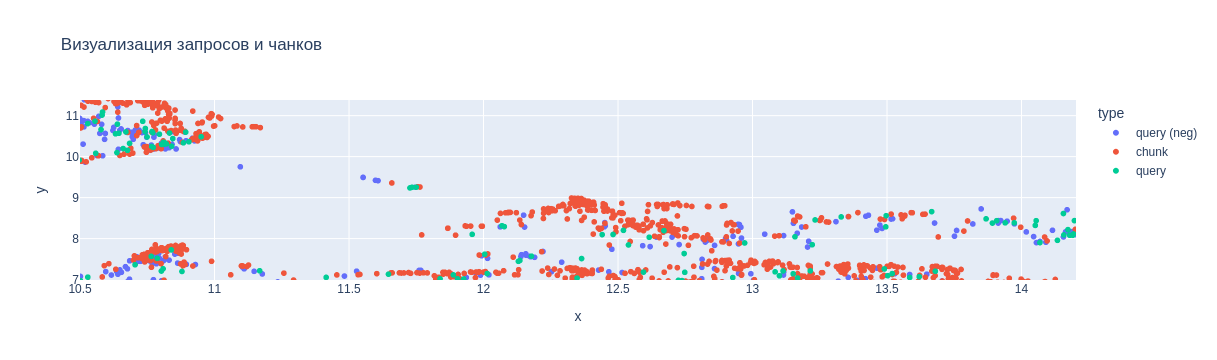

In [53]:
import random
import pandas as pd
import numpy as np
import umap
import plotly.express as px
from sentence_transformers import SentenceTransformer

# --- 1. Берём подвыборку из датасета ---
num_samples = 15000
sampled = random.sample(dataset, min(num_samples, len(dataset)))

# --- 2. Готовим тексты для эмбеддинга ---
texts = []
categories = []  # что за объект: query / chunk
pairs_map = []   # id пары (чтобы можно было связать)

for i, (query, chunk, label) in enumerate(sampled):
    texts.append(query)
    categories.append("query" if label == 1 else "query (neg)")
    pairs_map.append(i)

    texts.append(chunk)
    categories.append("chunk")
    pairs_map.append(i)

# --- 3. Загружаем обученную модель и строим эмбеддинги ---
model = SentenceTransformer("./wh_sentence_model_4")
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)

# --- 4. Уменьшаем размерность до 2D ---
reducer = umap.UMAP(n_components=2, random_state=42)
reduced = reducer.fit_transform(embeddings)

# --- 5. Делаем DataFrame для удобства ---
df = pd.DataFrame({
    "x": reduced[:, 0],
    "y": reduced[:, 1],
    "text": [str(t)[:80] + "..." for t in texts],  # обрезаем текст
    "type": categories,
    "pair_id": pairs_map
})

# --- 6. Интерактивная визуализация ---
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="type",         # выделяем query / chunk
    hover_data=["text", "pair_id"],  # показываем текст и id пары
    title="Визуализация запросов и чанков"
)

fig.show()


# Обучение реранкера

In [1]:
import pickle

# Загрузка
with open("dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [2]:
dataset[0]

('какие боевые потери понёс орден Истребителей во время битвы с бандой Багровой Резни?',
 '101-й полк Бета-Драконов приобрёл известность в субсекторе Гоанкс после того, как пришёл на помощь космодесантникам из ордена Истребителей . Адептус Астартес защищали вулканический мир смерти от банды Багровой Резни . Многие из штурмовых мотоциклов ордена были уничтожены стаей хэлбрутов , а хель-драконы повредили два « Грозовых когтя ». « Валькирии » Драконов атаковали хель-драконов, заставив жуткие демонические машины вступить с ними в бой, что позволило Отпрыскам высадиться незамеченными. Их « Тауроксы -прим» тотчас направились в сторону хэлбрутов и ввели безумных шагателей в ярость огнём из боевых пушек. Хэлбруты затопали за транспортами Отпрысков, рванувшимися вверх по склону вулкана. Боевые машины Хаоса уже были повреждены космодесантниками Истребителей и не могли угнаться за «Тауроксами», несмотря на своё неистовство. Отпрыски покинули машины и скрылись среди камней на краю вулкана. Как тол

In [13]:
from app.embedding_model import MLMEmbeddings
import torch
import numpy as np
from app.embedding_model import MLMEmbeddings

embedding_model = MLMEmbeddings("./wh_sentence_model_ft")

In [3]:
from app.embedding_model import MLMEmbeddings
import torch
import numpy as np
from app.embedding_model import MLMEmbeddings

embedding_model = MLMEmbeddings("./wh_sentence_model_ft")

# фильтруем не-строки
questions = [str(x[0]) for x in dataset if x[0] is not None]
chunks = [str(x[1]) for x in dataset if x[1] is not None]
labels = [x[2] for x in dataset if x[0] is not None and x[1] is not None]

print(len(questions), len(chunks), len(labels))


# преобразуем в torch.Tensor
emb_q = torch.tensor(embedding_model.embed_documents_batch(questions))
emb_chunk = torch.tensor(embedding_model.embed_documents_batch(chunks))
labels = torch.tensor(labels)



/home/alex/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


401400 401400 401400


In [4]:
torch.save(emb_q, "emb_q.pt")
torch.save(emb_chunk, "emb_chunk.pt")
torch.save(labels, "labels.pt")

In [6]:
emb_q = torch.load("emb_q.pt")
emb_chunk = torch.load("emb_chunk.pt")
labels = torch.load("labels.pt")

In [21]:
from torch.utils.data import Dataset, DataLoader

class EmbeddingDataset(Dataset):
    def __init__(self, emb_q, emb_chunk, labels):
        self.emb_q = emb_q
        self.emb_chunk = emb_chunk
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "emb_q": self.emb_q[idx],
            "emb_chunk": self.emb_chunk[idx],
            "label": self.labels[idx]
        }

from sklearn.model_selection import train_test_split

emb_q_train, emb_q_val, emb_chunk_train, emb_chunk_val, labels_train, labels_val = train_test_split(
    emb_q, emb_chunk, labels, test_size=0.2, random_state=42
)

train_dataset = EmbeddingDataset(emb_q_train, emb_chunk_train, labels_train)
val_dataset = EmbeddingDataset(emb_q_val, emb_chunk_val, labels_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)



In [40]:
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingClassifier(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.fc1 = nn.Linear(4*emb_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, emb_q, emb_chunk):
        x = torch.cat([
            emb_q,
            emb_chunk,
            torch.abs(emb_q - emb_chunk),
            emb_q * emb_chunk
        ], dim=-1)

        x = F.gelu(self.bn1(self.fc1(x)))
        x = F.gelu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return 3 * x  # усиливаем контраст


In [41]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.utils as torch_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_size = emb_q.shape[1]
model = EmbeddingClassifier(emb_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Шедулер уменьшает LR, если вал f1 не растет
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, verbose=True, min_lr=1e-6)

best_val_f1 = 0
patience = 3
trigger_times = 0
epochs = 30

for epoch in range(epochs):
    # ======== Тренировка ========
    model.train()
    total_loss = 0
    all_labels, all_preds = [], []

    for batch in train_loader:
        optimizer.zero_grad()
        emb_q_batch = batch["emb_q"].to(device)
        emb_chunk_batch = batch["emb_chunk"].to(device)
        labels_batch = batch["label"].float().to(device)

        logits = model(emb_q_batch, emb_chunk_batch).squeeze()
        loss = criterion(logits, labels_batch)
        loss.backward()

        # Градиентный клиппинг
        torch_utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_preds.extend(preds)
        all_labels.extend(labels_batch.cpu().numpy())

    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds)

    # ======== Валидация ========
    model.eval()
    val_labels, val_preds = [], []
    with torch.no_grad():
        for batch in val_loader:
            emb_q_batch = batch["emb_q"].to(device)
            emb_chunk_batch = batch["emb_chunk"].to(device)
            labels_batch = batch["label"].float().to(device)

            logits = model(emb_q_batch, emb_chunk_batch).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            val_preds.extend(preds)
            val_labels.extend(labels_batch.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"train_loss={total_loss/len(train_loader):.4f}, train_acc={train_acc:.4f}, train_f1={train_f1:.4f} | "
          f"val_acc={val_acc:.4f}, val_f1={val_f1:.4f}")

    # Шедулер проверяет вал f1
    scheduler.step(val_f1)

    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping")
            break


Epoch 1/30, train_loss=0.1598, train_acc=0.9361, train_f1=0.9038 | val_acc=0.8772, val_f1=0.8127
Epoch 2/30, train_loss=0.1463, train_acc=0.9408, train_f1=0.9113 | val_acc=0.8768, val_f1=0.8078
Epoch 3/30, train_loss=0.1378, train_acc=0.9437, train_f1=0.9157 | val_acc=0.8761, val_f1=0.8108
Epoch 4/30, train_loss=0.1242, train_acc=0.9495, train_f1=0.9243 | val_acc=0.8753, val_f1=0.8080
Early stopping


In [42]:
test_chunks = [
    "Имя Нургл происходит от Нург-лет — имени бога на языке Хаоса .\n\nОПИСАНИЕ [ ]\n\nНургл — Повелитель Разложения и Владыка Мора и Чумы, одна из четырёх главных Губительных Сил. Он является третьим из богов Хаоса , полностью пробудившимся в варпе , появившись во 2-м тысячелетии во время Средневековья Терры , когда великие чумные бедствия охватили весь мир, предвещая его рождение. Его главным соперником является Тзинч , Владыка Перемен, так как их силы происходят из противоположных источников. Сила Тзинча — надежда и амбиции, в то время как Нургл черпает мощь из страха, рождённого отчаяньем и безнадежностью.\n\nПАРАДОКСАЛЬНАЯ ВЕРА [ ]",
    
    "Нурглики, безусловно, существа общественные, и при первой же возможности будут искать себе подобных, однако некоторые предпочитают затаиться в трущобах городов, питаясь в грудах мусора, канализациях и тому подобных местах. Как ни удивительно, но время от времени нурглики, рождённые не от Нечистого, отправляются на поиски изначального носителя, дабы в качестве благодарности своему родителю одарить того благословением чумы.\nНурглики редко нападают в одиночку, предпочитая собираться в рои тараторящих и щебечущих зелёных тел. Они кусают и царапают ноги врага, облизывая нанесённые раны и ссадины. Зубы демонят острые, словно иглы, и оставляют гноящиеся следы от укусов, однако редко в состоянии убить сразу.",
    
    "Нурн Дельта — это мир искалеченных ветром равнин и дикарей, едва способных говорить и заботящихся лишь об убийстве себе подобных камнями. Подобное сочетание изоляции, очевидного отсутствия природных ресурсов и крайне сильно одичавшего населения привело к тому, что немногие аскеллонские корабли посещают эту планету. Корабли иных регионов временами прилетаю сюда, но только по исключительным причинам.\nОдин раз за поколение корабль, украшенный цветами ярчайшего неба и чистейших облаков, прибывает по вапр-маршруту, неизвестному ни одному навигаторскому дому Аскеллона. Небольшие группы огромных воинов внезапно высаживаются на поверхность в место и время, предсказанные во время предыдущего посещения.",
    
    "Считается, что с тех пор грав-«Носороги» больше не используются Адептус Кустодес, поскольку те открыто не покидали Императорский Дворец на Терре до наступления Эры Неодолимости и, таким образом, до недавнего времени довольно редко использовали свою технику на поле боя. Передовая антигравитационная технология, которая применялась при создании этих машин, в настоящее время утрачена Империумом . Однако считается, что в обширном арсенале Десяти Тысяч всё ещё могут храниться исправные грав-«Носороги».",
    
    "Как и в случае многих артефактов, порождённых Хаосом, происхождение гнилостных гранат лежит в самых мрачных легендах. Нургл, как известно даже самому низкому ученику в области демонических знаний, — это Отец Чумы, создатель осп и поветрий. Желая узнать, насколько опасным является каждое из его творений, Нургл поручает своим легионам чумоносцев вести учет каждого существа, смертного и бессмертного, которое поддается каждому штамму вирусов. До определенного момента чумоносцы могут отслеживать эти огромные цифры, но даже демоны не в состоянии поддерживать точность вечно — им нужен какой-то механизм для записи своих подсчетов. Для упрощения этого монументального задания чумоносцы строят массивные счеты из ржавых железных столбов и голов жертв чумы. На каждую спицу нанизаны\xa0многие тысячи этих ужасных «костяшек», каждая из которых наполнена кишащей личинками жидкостью, изобилующей ядовитыми и заразными мерзостями. Но это не попытка осквернения — ибо демонам чужды цели смертных — скорее всего, чумоносцы считают вид голов, «плачущих» нечистотами, более приятным своему единственному глазу.",
    
    "Жизненно необходимая вещь для длительного и надёжного хранения важных образцов и зловещих артефактов, ноль-коробка являет собой портативный генератор стазис -поля в форме небольшого бронированного ящичка. Некоторые из них, впрочем, могут быть размером с большой сундук или саркофаг. Внутри стазис-поля в буквальном смысле замирает время и пространство – содержимое саркофага никоим образом не способно взаимодействовать с любой реальностью – кроме всего прочего, саркофаг и его содержимое находятся в «мёртвой», недоступной для любого типа психического воздействия зоне. Истинные реликты времен Тёмной Эры Технологии , ноль-коробки невероятно крепки и прочны (сверхъестественная способность противостоять любому урону может быть объяснена воздействием генерируемого ими временного поля), а после активации им уже не требуются какие-либо источники энергии – вплоть до повторного включения. По вполне очевидным причинам контрольные механизмы ноль-коробок зачастую сокрыты и тщательно кодированы. Если коробку не отключить или не вывести из строя приложением некой невероятной силы, то коробка и её содержимое будут пребывать вне времени вечно.",
    
    "Астральные Ножи (англ. Astral Knives )\xa0— культ смерти рождённых в пустоте , существовавший долгие века и столь же долго терпимый. В 792.М41 культ Астральных Ножей был объявлен извращённым связями с тёмными силами и признан Священными Ордосами Инквизиции еретическим .\n\nОПИСАНИЕ [ ]",
    
    "Но чего не ведают эти весёлые, но недалекие демоны , так это того, что их тела источают массу смертельных болезней и инфекций. Даже просто близости твари Нургла достаточно для гибели мелких животных и растений. Одно лишь прикосновение такого создания приносит быструю смерть большинству людей, вызывая быстротекущее заражение, которое мгновенно охватывает всё тело. Очень скоро жертва умолкает и перестает двигаться, уже разлагаясь от пагубного воздействия Нургловых инфекций.",
    
    "Всего признаётся 73 стабильных генотипа нелюдей, из которых 46 вымерли, по существовании ещё 12 данные отсутствуют (скорее всего, тоже вымерли или ассимилировались), а остальные 15 являются предметом постоянных споров в Десятинной палате нотариата (подотдел планетарной переписи — административное подразделение, целиком посвящённое вопросам классификации нелюдей). Именно там решается вопрос о том, признать тот или иной генотип человеческим, недочеловеческим или «мутантским», то есть подлежащим истреблению. Каждому признанному генотипу присваивается биологическое название в составе вида Homo sapiens.",
    
    "Сейчас лишь Адептус Механикус обладают знаниями о создании «Носорогов» (несмотря на то, что их с легкостью можно было бы делать на любой планете Империума, обладающей копией чертежей «Носорога»). Каждая машина проходит обряд очищения и благословляется, каждая запчасть умиротворяется, прежде чем быть помещенной на свое место. Если «Носорог» уничтожается в бою, его спасают и восстанавливают, затем посылая его обратно в сражение, дабы Дух Машины получил возможность отомстить своим врагам."
]

In [43]:
# ======= Тестовый пример после обучения =======
model.eval()

# Пример данных
test_question = "Кто такой Нургл?"

# Эмбеддинги
emb_q_test = torch.tensor(embedding_model.embed_documents_batch([test_question]*len(test_chunks))).to(device)
emb_chunks_test = torch.tensor(embedding_model.embed_documents_batch(test_chunks)).to(device)

# Предсказания
with torch.no_grad():
    logits = model(emb_q_test, emb_chunks_test).squeeze()
    probs = torch.sigmoid(logits).cpu().numpy()

# Сортировка по вероятности
ranked = sorted(zip(test_chunks, probs), key=lambda x: x[1], reverse=True)

print("=== Ранжирование чанков ===")
for text, score in ranked:
    print(f"{score:.3f} | {text[:150]}...")


=== Ранжирование чанков ===
0.996 | Имя Нургл происходит от Нург-лет — имени бога на языке Хаоса .

ОПИСАНИЕ [ ]

Нургл — Повелитель Разложения и Владыка Мора и Чумы, одна из четырёх гла...
0.991 | Нурглики, безусловно, существа общественные, и при первой же возможности будут искать себе подобных, однако некоторые предпочитают затаиться в трущоба...
0.986 | Как и в случае многих артефактов, порождённых Хаосом, происхождение гнилостных гранат лежит в самых мрачных легендах. Нургл, как известно даже самому ...
0.984 | Нурн Дельта — это мир искалеченных ветром равнин и дикарей, едва способных говорить и заботящихся лишь об убийстве себе подобных камнями. Подобное соч...
0.931 | Считается, что с тех пор грав-«Носороги» больше не используются Адептус Кустодес, поскольку те открыто не покидали Императорский Дворец на Терре до на...
0.925 | Всего признаётся 73 стабильных генотипа нелюдей, из которых 46 вымерли, по существовании ещё 12 данные отсутствуют (скорее всего, тоже вымерли или асс...


In [38]:
torch.save(model.state_dict(), "embedding_classifier.pth")

In [3]:
model = EmbeddingClassifier(emb_size)  # нужно заново создать объект модели
model.load_state_dict(torch.load("embedding_classifier.pth", map_location=device))
model.to(device)
model.eval()

NameError: name 'emb_size' is not defined

In [13]:
emb_size

384